In [116]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from dython.nominal import associations
import seaborn as sns
import pypyodbc as odbc
import squarify
import pyodbc
import glob
import os
from sklearn.linear_model import LinearRegression #mô hình hồi quy tuyến tính
import statistics as sta
import math
import requests
from io import StringIO
print('Completed import lib')

Completed import lib


In [117]:
def remove_outliers(data, x):
    q25 = data[x].quantile(0.25)
    q75 = data[x].quantile(0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower = q25 - cut_off
    upper = q75 + cut_off
    data = data[(data[x] < upper) & (data[x] > lower)]
    print(f"Outliers of {x} are removed\n")
    return data

# I. Load data set và xử lý qua

In [118]:
df = pd.read_csv('loans_full_schema.csv')
df

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,owner,10.0,TX,RENT,108000.0,Source Verified,22.28,NaN,NaN,NaN,...,A4,Jan-2018,Current,whole,Cash,21586.34,2969.80,2413.66,556.14,0.0
9996,director,8.0,PA,MORTGAGE,121000.0,Verified,32.38,NaN,NaN,NaN,...,D3,Feb-2018,Current,whole,Cash,9147.44,1456.31,852.56,603.75,0.0
9997,toolmaker,10.0,CT,MORTGAGE,67000.0,Verified,45.26,107000.0,Source Verified,29.57,...,E2,Feb-2018,Current,fractional,Cash,27617.65,4620.80,2382.35,2238.45,0.0
9998,manager,1.0,WI,MORTGAGE,80000.0,Source Verified,11.99,NaN,NaN,NaN,...,A1,Feb-2018,Current,whole,Cash,21518.12,2873.31,2481.88,391.43,0.0


In [119]:
df.isnull().sum()

emp_title                            833
emp_length                           817
state                                  0
homeownership                          0
annual_income                          0
verified_income                        0
debt_to_income                        24
annual_income_joint                 8505
verification_income_joint           8545
debt_to_income_joint                8505
delinq_2y                              0
months_since_last_delinq            5658
earliest_credit_line                   0
inquiries_last_12m                     0
total_credit_lines                     0
open_credit_lines                      0
total_credit_limit                     0
total_credit_utilized                  0
num_collections_last_12m               0
num_historical_failed_to_pay           0
months_since_90d_late               7715
current_accounts_delinq                0
total_collection_amount_ever           0
current_installment_accounts           0
accounts_opened_

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9167 non-null   object 
 1   emp_length                        9183 non-null   float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    9976 non-null   float64
 7   annual_income_joint               1495 non-null   float64
 8   verification_income_joint         1455 non-null   object 
 9   debt_to_income_joint              1495 non-null   float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          4342 non-null   float64
 12  earli

In [121]:
df['emp_title'].fillna(value='Other', inplace=True)
df['verification_income_joint'].fillna(value='Other', inplace=True)
# df['emp_length'].fillna(value=df['emp_length'].mean(), inplace=True)
# df['debt_to_income'].fillna(value=df['debt_to_income'].mean(), inplace=True)

df = df.fillna(df.mean())

C:\Users\dk201\AppData\Local\Temp/ipykernel_12340/2077001466.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


- Dữ liệu category có giá trị NA sẽ được thay thế bằng giá trị Other
- Dữ liệu dạng numberic có giá trị NA sẽ được thay thế bằng giá trị trung bình của cột giá trị đó

In [122]:
df.describe()

,emp_length,annual_income,debt_to_income,annual_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,...,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.00000,10000.00000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.930306,7.922215e+04,19.308192,1.279146e+05,19.979304,0.21600,36.760709,2001.29000,1.95820,22.679600,...,0.123800,16361.922500,43.272000,12.427524,476.205323,14458.916610,2494.234773,1894.448466,599.666781,0.119516
std,3.549197,6.473429e+04,14.986833,2.712304e+04,3.113514,0.68366,14.255166,7.79551,2.38013,11.885439,...,0.337172,10301.956759,11.029877,5.001105,294.851627,9964.561865,3958.230365,3884.407175,517.328062,1.813468
min,0.000000,0.000000e+00,0.000000,1.920000e+04,0.320000,0.00000,1.000000,1963.00000,0.00000,2.000000,...,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.500000e+04,11.067500,1.279146e+05,19.979304,0.00000,36.760709,1997.00000,0.00000,14.000000,...,0.000000,8000.000000,36.000000,9.430000,256.040000,6679.065000,928.700000,587.100000,221.757500,0.000000
50%,5.930306,6.500000e+04,17.600000,1.279146e+05,19.979304,0.00000,36.760709,2003.00000,1.00000,21.000000,...,0.000000,14500.000000,36.000000,11.980000,398.420000,12379.495000,1563.300000,984.990000,446.140000,0.000000
75%,10.000000,9.500000e+04,24.990000,1.279146e+05,19.979304,0.00000,36.760709,2006.00000,3.00000,29.000000,...,0.000000,24000.000000,60.000000,15.050000,644.690000,20690.182500,2616.005000,1694.555000,825.420000,0.000000
max,10.000000,2.300000e+06,469.090000,1.100000e+06,39.980000,13.00000,118.000000,2015.00000,29.00000,87.000000,...,3.000000,40000.000000,60.000000,30.940000,1566.590000,40000.000000,41630.443684,40000.000000,4216.440000,52.980000


## Nhật xét tập dữ liệu:
    - Dữ liệu gồm 55 biến và 10.000 dòng dữ liệu
    - Dữ liệu NA nằm tại các biến: 
        + emp_title, emp_length, debt_to_income, annual_income_joint, verification_income_joint,   debt_to_income_joint,  months_since_last_delinq, months_since_90d_late, months_since_last_credit_inquiry, num_accounts_120d_past_due.
        + trong đó có một số biến quan trọng về mặt lý thuyết tài chính, do vậy việc thiếu dữ liệu có thể ảnh hưởng đến tính chính xác của độ tương quan giữa biến đó với lãi suất.
    - Dữ liệu NA sẽ được xử lý trong quá trình xử lý data

# 

# Chuyển đổi dữ liệu và xác định độ tương quan của các biến với biến lãi suất

In [123]:
df.describe(include = 'object')

,emp_title,state,homeownership,verified_income,verification_income_joint,loan_purpose,application_type,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,4742,50,3,3,4,12,2,7,32,3,6,2,2
top,Other,CA,MORTGAGE,Source Verified,Other,debt_consolidation,individual,B,B1,Mar-2018,Current,whole,Cash
freq,833,1330,4789,4116,8545,5144,8505,3037,647,3617,9375,8206,9284


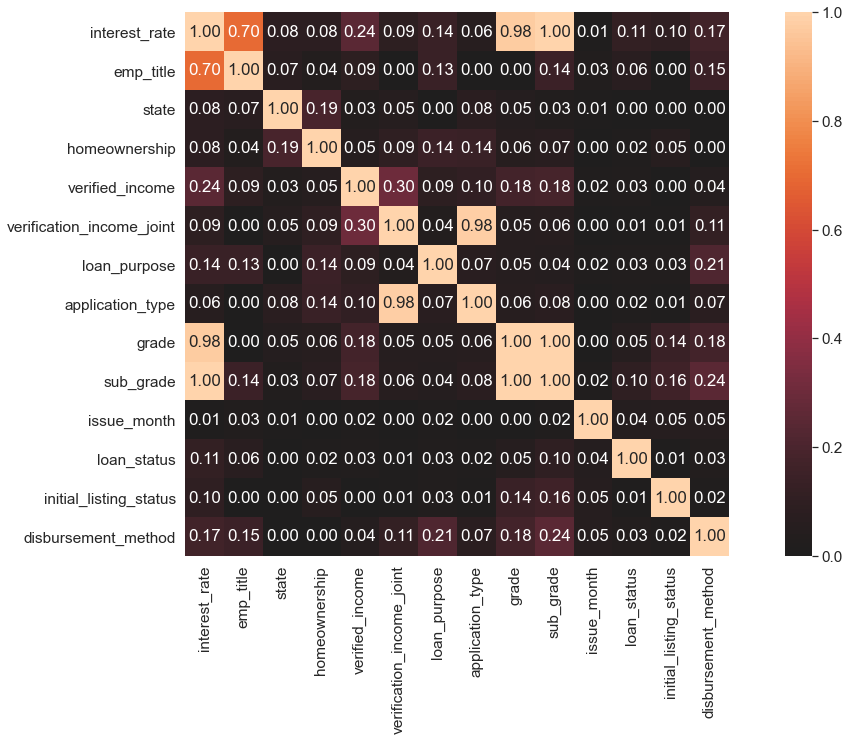

{'corr':                            interest_rate  emp_title     state  homeownership  \
 interest_rate                   1.000000   0.696759  0.079026       0.080557   
 emp_title                       0.696759   1.000000  0.067349       0.038106   
 state                           0.079026   0.067349  1.000000       0.187920   
 homeownership                   0.080557   0.038106  0.187920       1.000000   
 verified_income                 0.243823   0.086304  0.033115       0.052994   
 verification_income_joint       0.093677   0.000000  0.050267       0.094805   
 loan_purpose                    0.138838   0.133684  0.000000       0.142468   
 application_type                0.061201   0.000000  0.076401       0.135708   
 grade                           0.975167   0.000000  0.046657       0.056599   
 sub_grade                       0.999188   0.142214  0.029257       0.065262   
 issue_month                     0.011122   0.031219  0.014888       0.000000   
 loan_status        

In [124]:
associations(df[['interest_rate','emp_title','state','homeownership','verified_income','verification_income_joint','loan_purpose','application_type','grade','sub_grade',
                 'issue_month','loan_status','initial_listing_status','disbursement_method']],figsize=(20,10))

- Dữ liệu có 13 biến thuộc dạng dữ liệu category
- 8 biến có corr > 0.1 sẽ được sử dụng trong model.

In [125]:
corr_price = df[df.columns[:]].corr()['interest_rate'][:]
corr_price

emp_length                         -0.028405
annual_income                      -0.099584
debt_to_income                      0.141393
annual_income_joint                -0.068583
debt_to_income_joint                0.110519
delinq_2y                           0.090456
months_since_last_delinq           -0.053720
earliest_credit_line                0.103635
inquiries_last_12m                  0.131193
total_credit_lines                 -0.044435
open_credit_lines                  -0.012773
total_credit_limit                 -0.130497
total_credit_utilized               0.031527
num_collections_last_12m            0.029901
num_historical_failed_to_pay        0.037563
months_since_90d_late              -0.033451
current_accounts_delinq             0.007184
total_collection_amount_ever        0.013532
current_installment_accounts        0.047131
accounts_opened_24m                 0.120657
months_since_last_credit_inquiry   -0.094503
num_satisfactory_accounts          -0.013330
num_accoun

- Các biến có corr >= 0.1 hoặc 0 > a >= -0.1 sẽ được sủ dụng 

# Visualizations:

In [126]:
features = df[['emp_title','verified_income','loan_purpose','grade','sub_grade',
              'loan_status','initial_listing_status','disbursement_method','annual_income','debt_to_income','annual_income_joint','debt_to_income_joint','earliest_credit_line','inquiries_last_12m',
              'total_credit_limit','accounts_opened_24m','total_debit_limit','term','num_mort_accounts','account_never_delinq_percent','installment','interest_rate']]
features

,emp_title,verified_income,loan_purpose,grade,sub_grade,loan_status,initial_listing_status,disbursement_method,annual_income,debt_to_income,...,earliest_credit_line,inquiries_last_12m,total_credit_limit,accounts_opened_24m,total_debit_limit,term,num_mort_accounts,account_never_delinq_percent,installment,interest_rate
0,global config engineer,Verified,moving,C,C3,Current,whole,Cash,90000.0,18.01,...,2001,6,70795,5,11100,60,1,92.9,652.53,14.07
1,warehouse office clerk,Not Verified,debt_consolidation,C,C1,Current,whole,Cash,40000.0,5.04,...,1996,1,28800,11,16500,36,0,100.0,167.54,12.61
2,assembly,Source Verified,other,D,D1,Current,fractional,Cash,40000.0,21.15,...,2006,4,24193,13,4300,36,0,93.5,71.40,17.09
3,customer service,Not Verified,debt_consolidation,A,A3,Current,whole,Cash,30000.0,10.16,...,2007,0,25400,1,19400,36,0,100.0,664.19,6.72
4,security supervisor,Verified,credit_card,C,C3,Current,whole,Cash,35000.0,57.96,...,2008,7,69839,6,32700,36,0,100.0,786.87,14.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,owner,Source Verified,other,A,A4,Current,whole,Cash,108000.0,22.28,...,2008,5,199195,8,44600,36,1,100.0,744.90,7.35
9996,director,Verified,debt_consolidation,D,D3,Current,whole,Cash,121000.0,32.38,...,1994,1,382061,0,28200,36,2,82.1,366.72,19.03
9997,toolmaker,Verified,debt_consolidation,E,E2,Current,fractional,Cash,67000.0,45.26,...,2004,0,346402,4,14900,36,2,72.2,1175.10,23.88
9998,manager,Source Verified,other,A,A1,Current,whole,Cash,80000.0,11.99,...,1999,1,294475,2,46000,36,6,100.0,722.76,5.32


In [127]:
features.isnull().sum()

emp_title                       0
verified_income                 0
loan_purpose                    0
grade                           0
sub_grade                       0
loan_status                     0
initial_listing_status          0
disbursement_method             0
annual_income                   0
debt_to_income                  0
annual_income_joint             0
debt_to_income_joint            0
earliest_credit_line            0
inquiries_last_12m              0
total_credit_limit              0
accounts_opened_24m             0
total_debit_limit               0
term                            0
num_mort_accounts               0
account_never_delinq_percent    0
installment                     0
interest_rate                   0
dtype: int64

## loan_purpose

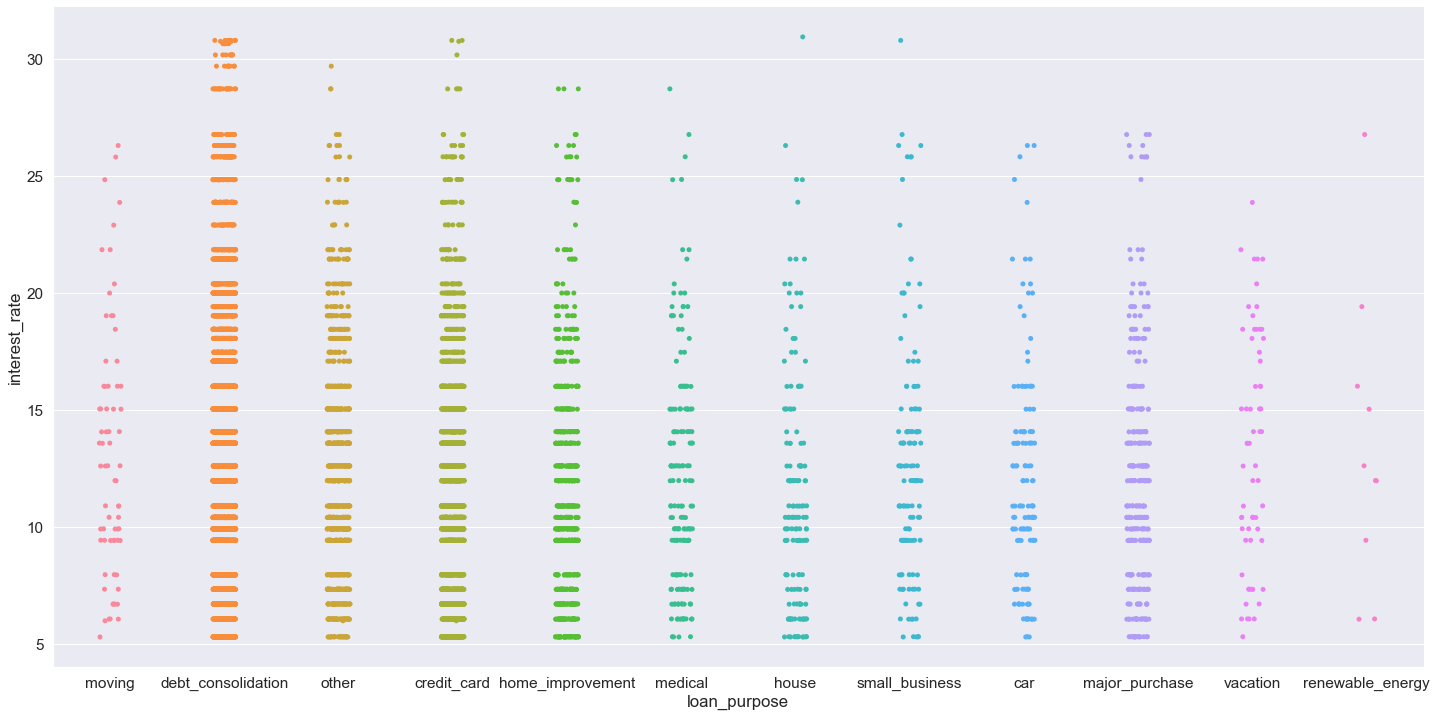

In [128]:
sns.set_style(style='white')
sns.set(font_scale=1.4)
sns.catplot(x='loan_purpose', y='interest_rate', data=features, height=10, aspect=2)

- debt_consolidation là mục đích vay nhiều nhất
- debt_consolidation, credit_card, house, small_business là những mục đích vay có lãi suất vay cao nhất.

## loan_status

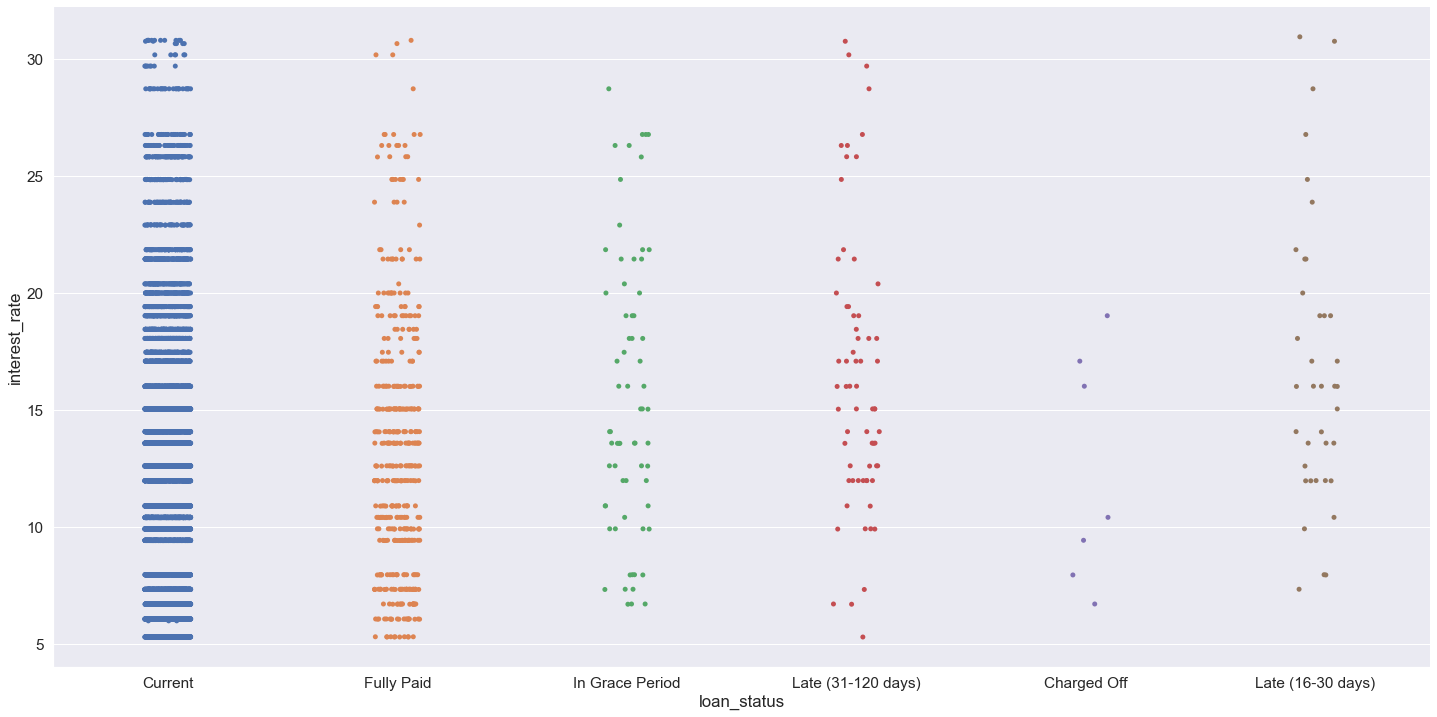

In [129]:
sns.set_style(style='white')
sns.set(font_scale=1.4)
sns.catplot(x='loan_status', y='interest_rate', data=features, height=10, aspect=2)

## initial_listing_status

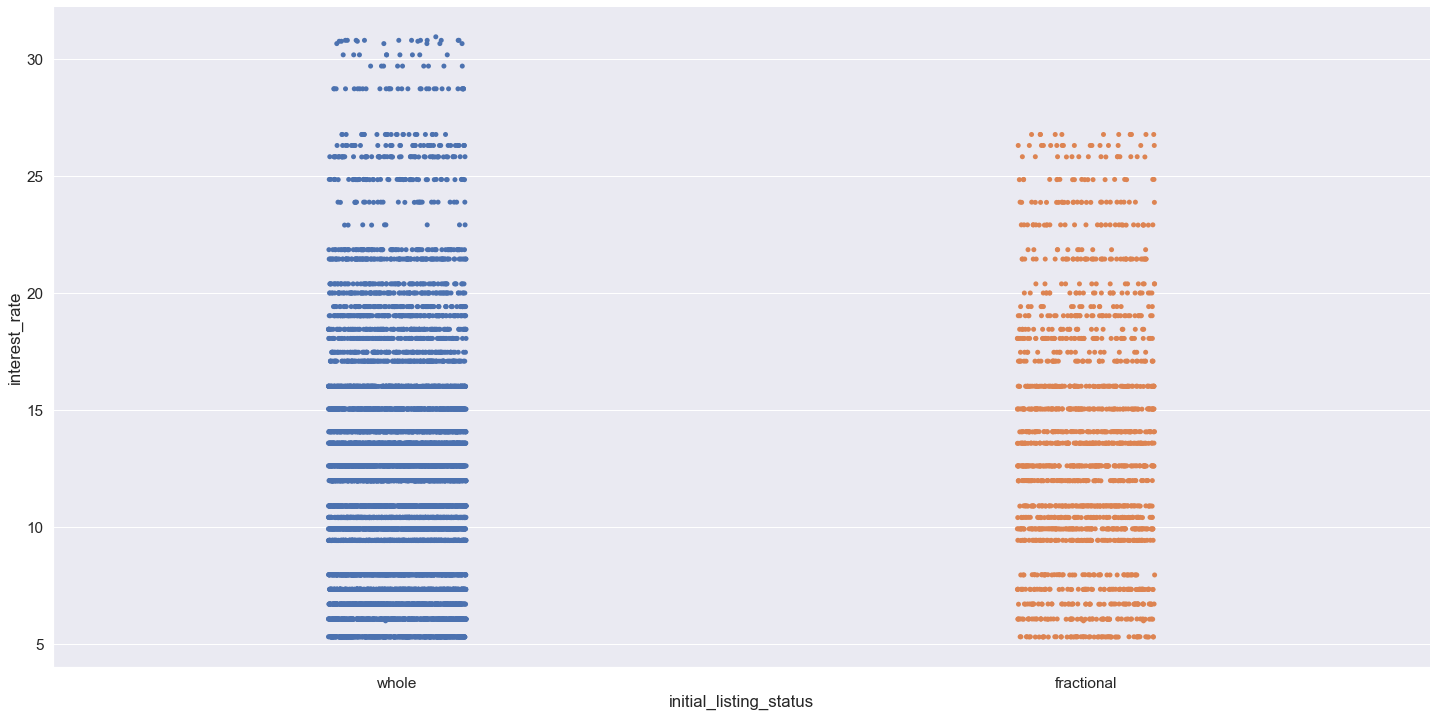

In [130]:
sns.set_style(style='white')
sns.set(font_scale=1.4)
sns.catplot(x='initial_listing_status', y='interest_rate', data=features, height=10, aspect=2)

## disbursement_method

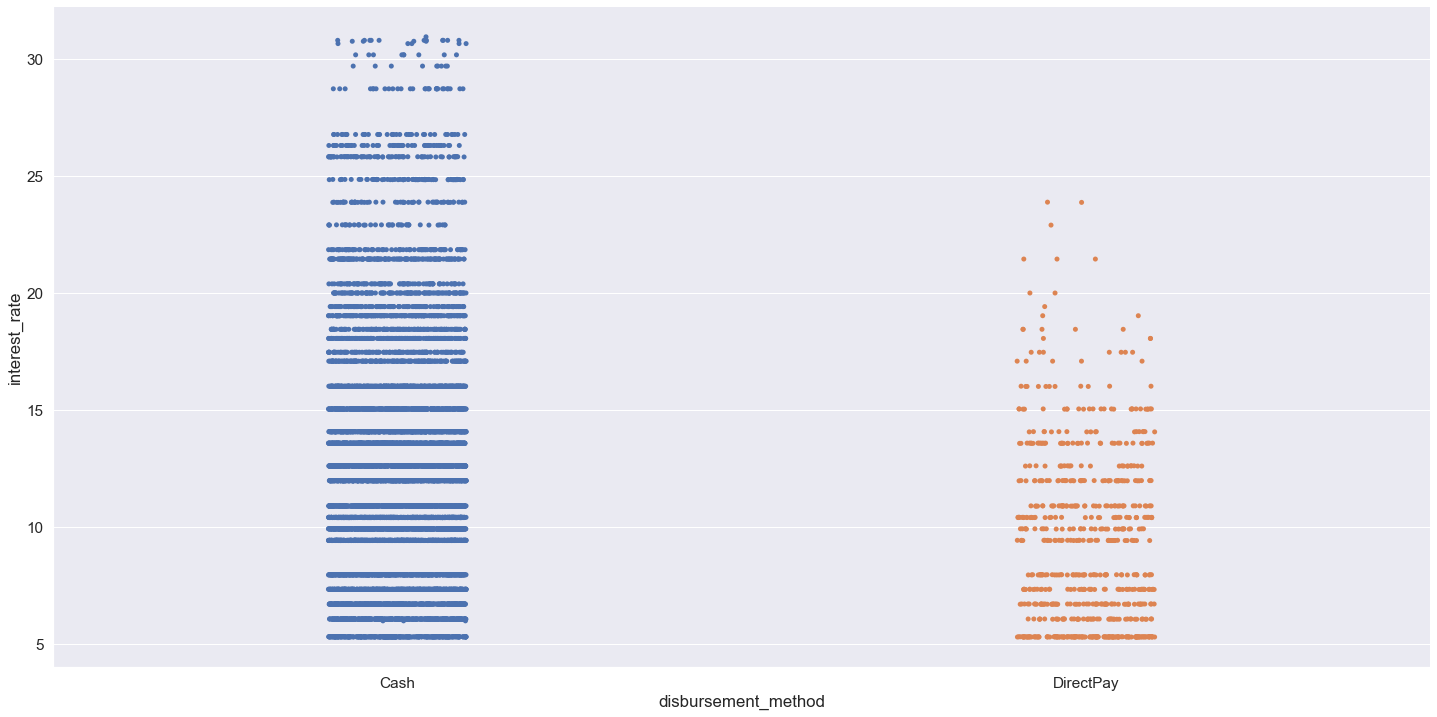

In [131]:
sns.set_style(style='white')
sns.set(font_scale=1.4)
sns.catplot(x='disbursement_method', y='interest_rate', data=features, height=10, aspect=2)

- Phương thức giả ngân phổ biến nhất là tiền mặt
- Giải ngân bằng tiền mặt mang lại nhiều khoản vay có lãi suất cao hơn phương thức khác    

Outliers of annual_income are removed

Outliers of debt_to_income are removed

Outliers of annual_income_joint are removed

Outliers of debt_to_income_joint are removed



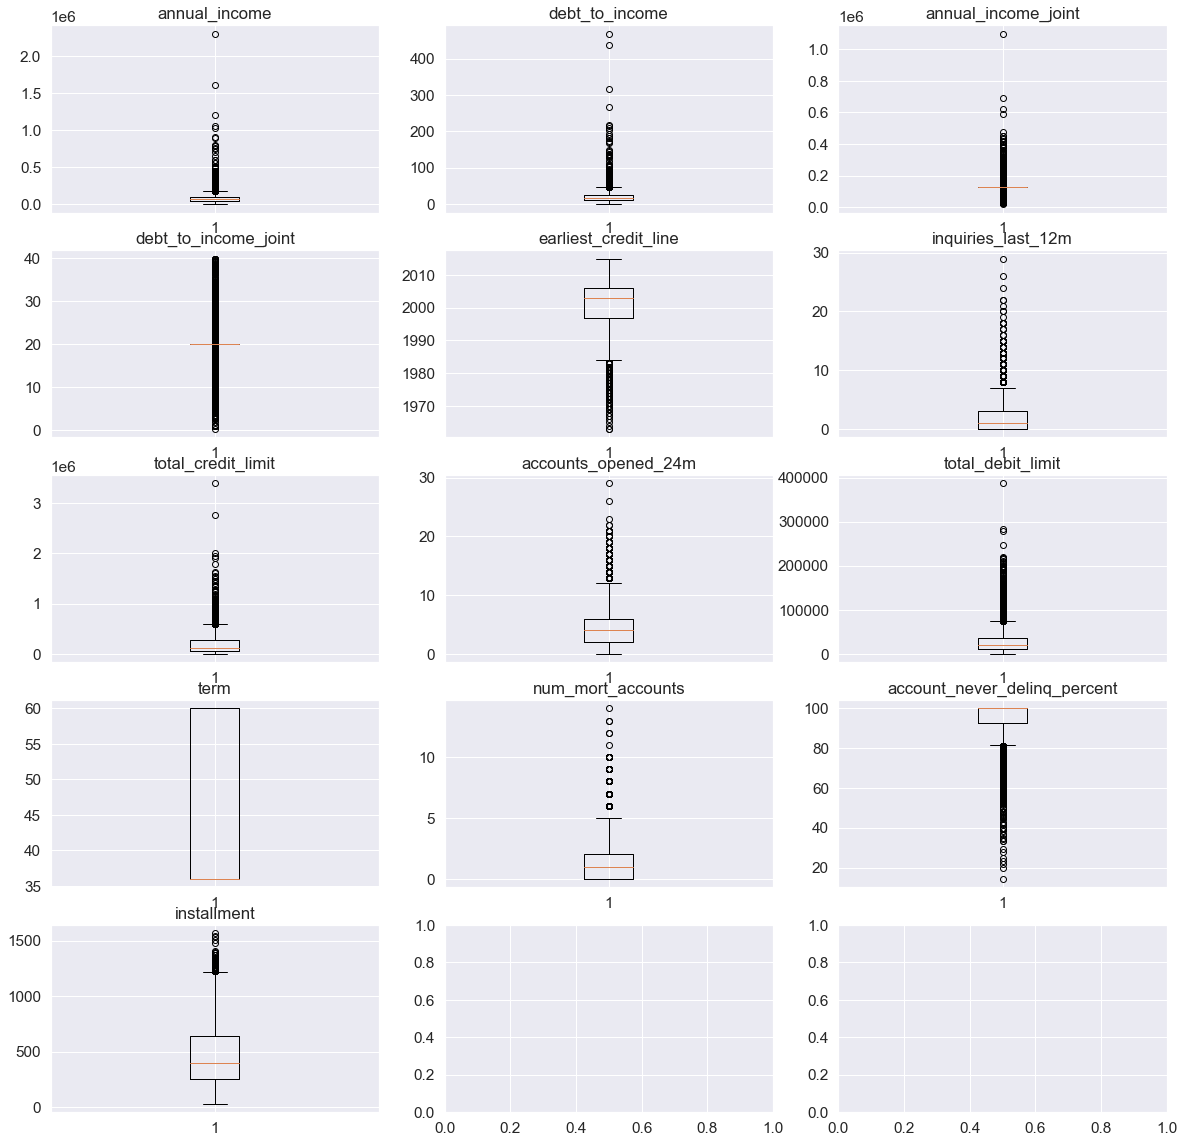

In [132]:
remove_outliers(features,'annual_income')
remove_outliers(features,'debt_to_income')
remove_outliers(features,'annual_income_joint')
remove_outliers(features,'debt_to_income_joint')


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6) ,(ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
fig.patch.set_facecolor('w')

ax1.boxplot(features['annual_income'])
ax2.boxplot(features['debt_to_income'])
ax3.boxplot(features['annual_income_joint'])
ax4.boxplot(features['debt_to_income_joint'])
ax5.boxplot(features['earliest_credit_line'])
ax6.boxplot(features['inquiries_last_12m'])
ax7.boxplot(features['total_credit_limit'])
ax8.boxplot(features['accounts_opened_24m'])
ax9.boxplot(features['total_debit_limit'])
ax10.boxplot(features['term'])
ax11.boxplot(features['num_mort_accounts'])
ax12.boxplot(features['account_never_delinq_percent'])
ax13.boxplot(features['installment'])




ax1.title.set_text('annual_income')
ax2.title.set_text('debt_to_income')
ax3.title.set_text('annual_income_joint')
ax4.title.set_text('debt_to_income_joint')
ax5.title.set_text('earliest_credit_line')
ax6.title.set_text('inquiries_last_12m')
ax7.title.set_text('total_credit_limit')
ax8.title.set_text('accounts_opened_24m')
ax9.title.set_text('total_debit_limit')
ax10.title.set_text('term')
ax11.title.set_text('num_mort_accounts')
ax12.title.set_text('account_never_delinq_percent')
ax13.title.set_text('installment')

Text(0, 0.5, 'Count')

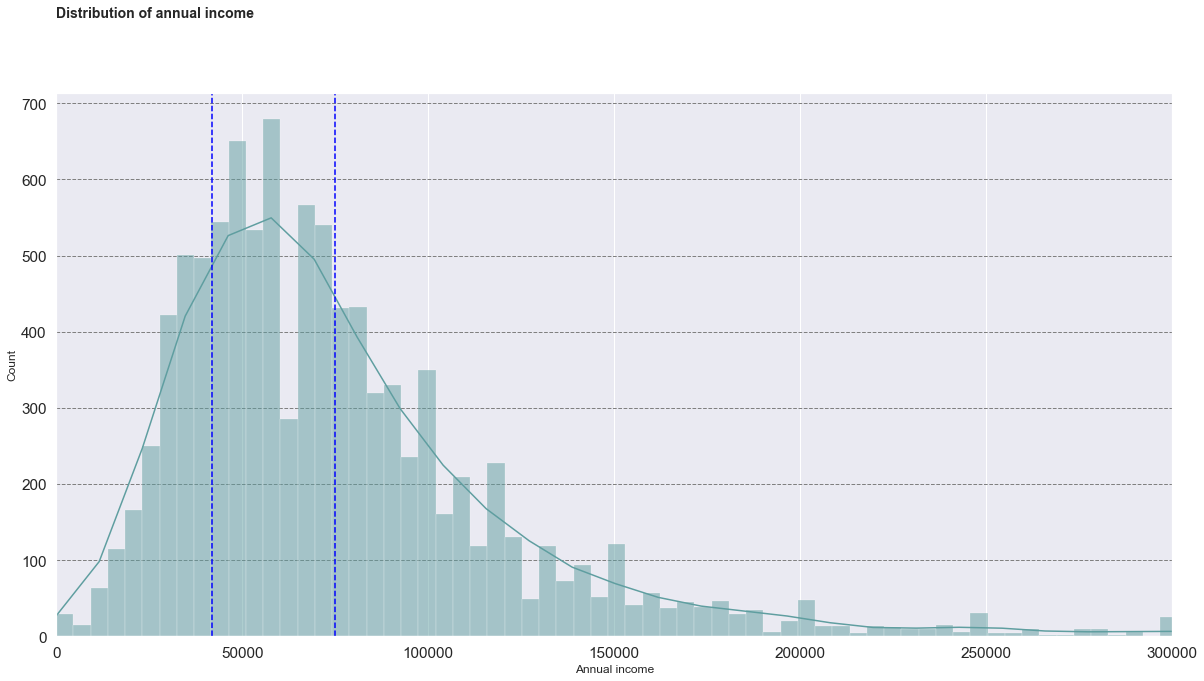

In [133]:
fig, ax = plt.subplots(figsize=(20, 10))

ax=sns.histplot(data=features, x='annual_income', kde=True, color='#5f9ea0')
ax.axvline(42000, color="blue", linestyle="--")
ax.axvline(75000, color="blue", linestyle="--")
plt.xlim(0, 300000)

ax.yaxis.grid(color='gray', linestyle='dashed')
# # bỏ đường kẻ ở trên và bên phải chart
# spines = ['top', 'right']
# for s in spines:
#     ax.spines[s].set_visible(False) 
    
# bỏ dấu tích ở 2 trục
# ax.tick_params(left=False) 

# thêm title, label các trục và source:
plt.suptitle('Distribution of annual income', fontweight='bold', size=14, horizontalalignment='left', x=0.125, y = 1)
#plt.title('2nd title', style='italic', size=12, loc='left')
plt.xlabel('Annual income', size=12)
plt.ylabel('Count', size=12)

## debt_to_income

Text(0, 0.5, 'Count')

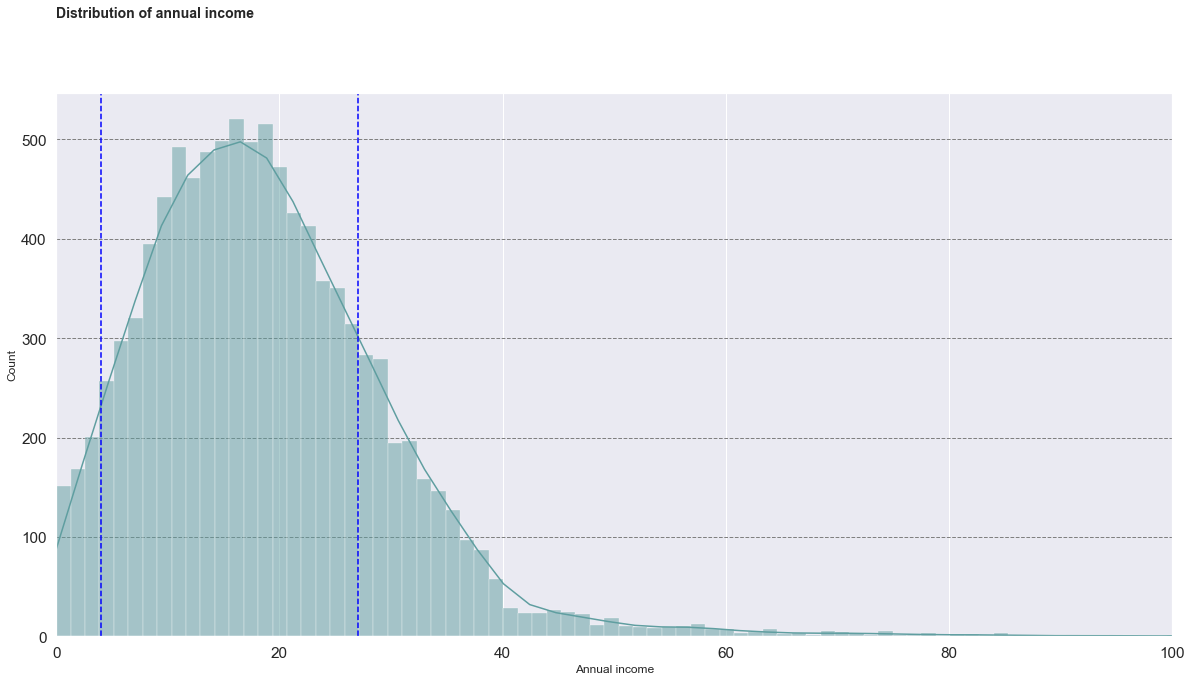

In [134]:
fig, ax = plt.subplots(figsize=(20, 10))

ax=sns.histplot(data=features, x='debt_to_income', kde=True, color='#5f9ea0')
ax.axvline(4, color="blue", linestyle="--")
ax.axvline(27, color="blue", linestyle="--")
plt.xlim(0, 100)

ax.yaxis.grid(color='gray', linestyle='dashed')
# # bỏ đường kẻ ở trên và bên phải chart
# spines = ['top', 'right']
# for s in spines:
#     ax.spines[s].set_visible(False) 
    
# bỏ dấu tích ở 2 trục
# ax.tick_params(left=False) 

# thêm title, label các trục và source:
plt.suptitle('Distribution of annual income', fontweight='bold', size=14, horizontalalignment='left', x=0.125, y = 1)
#plt.title('2nd title', style='italic', size=12, loc='left')
plt.xlabel('Annual income', size=12)
plt.ylabel('Count', size=12)

<function matplotlib.pyplot.show(close=None, block=None)>

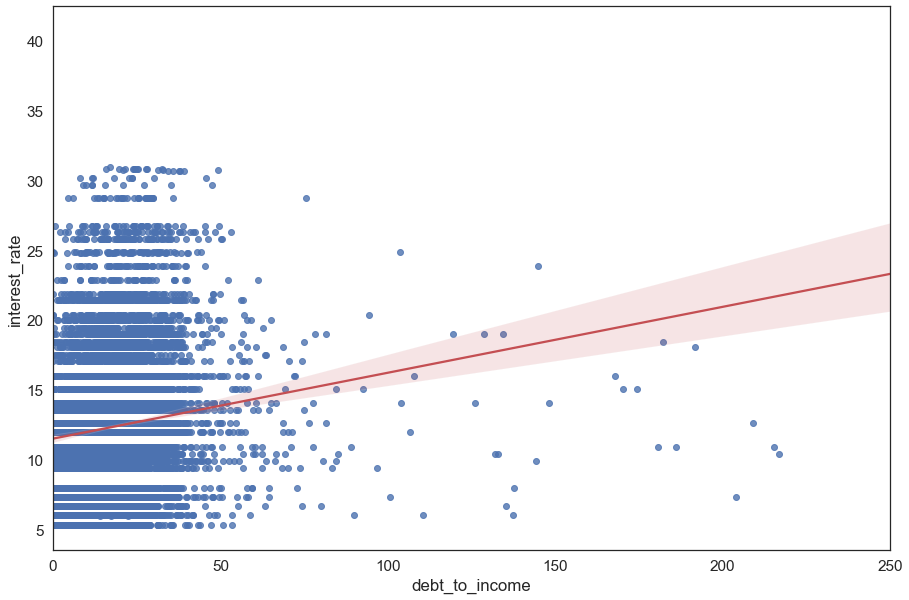

In [135]:
sns.set_style(style='white')
# sns.set(font_scale=1.5)
plt.figure(figsize=(15,10))
sns.regplot(x='debt_to_income', y='interest_rate', data=features,line_kws={"color":"r"})
plt.xlim(0,250)
plt.show

- Khách hàng vay tiền chủ yếu có tỷ lệ debt_to_income từ 4% đến 30%. 

In [136]:
features['verified_income'] = features['verified_income'].replace(['Verified','Not Verified','Source Verified'],[1,2,3])
features['loan_purpose'] = features['loan_purpose'].replace(['moving','debt_consolidation','other','credit_card',
                                                             'home_improvement','medical','house','small_business',
                                                             'car','major_purchase','vacation','renewable_energy'],[1,2,3,4,5,6,7,8,9,10,11,12])
features['grade'] = features['grade'].replace(['A','B','C','D','E','F','G'],[1,2,3,4,5,6,7])
features['sub_grade'] = features['sub_grade'].replace(['A1','A2','A3','A4','A5',
                                                       'B1','B2','B3','B4','B5',
                                                       'C1','C2','C3','C4','C5',
                                                       'D1','D2','D3','D4','D5',
                                                       'E1','E2','E3','E4','E5',
                                                       'F1','F2','F3','F4','F5',
                                                       'G1','G4'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32])
features['loan_status'] = features['loan_status'].replace(['Current','Fully Paid','In Grace Period','Late (31-120 days)','Charged Off','Late (16-30 days)'],[1,2,3,4,5,6])
features['initial_listing_status'] = features['initial_listing_status'].replace(['whole','fractional',],[1,2])
features['disbursement_method'] = features['disbursement_method'].replace(['Cash','DirectPay',],[1,2])
features['emp_title'] = features['emp_title'].replace(np.array(list(set(features['emp_title']))),np.array(range(1,4743)))
features.head(6)

C:\Users\dk201\AppData\Local\Temp/ipykernel_12340/294089856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['verified_income'] = features['verified_income'].replace(['Verified','Not Verified','Source Verified'],[1,2,3])
C:\Users\dk201\AppData\Local\Temp/ipykernel_12340/294089856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['loan_purpose'] = features['loan_purpose'].replace(['moving','debt_consolidation','other','credit_card',
C:\Users\dk201\AppData\Local\Temp/ipykernel_12340/294

,emp_title,verified_income,loan_purpose,grade,sub_grade,loan_status,initial_listing_status,disbursement_method,annual_income,debt_to_income,...,earliest_credit_line,inquiries_last_12m,total_credit_limit,accounts_opened_24m,total_debit_limit,term,num_mort_accounts,account_never_delinq_percent,installment,interest_rate
0,3298,1,1,3,13,1,1,1,90000.0,18.01,...,2001,6,70795,5,11100,60,1,92.9,652.53,14.07
1,4567,2,2,3,11,1,1,1,40000.0,5.04,...,1996,1,28800,11,16500,36,0,100.0,167.54,12.61
2,197,3,3,4,16,1,2,1,40000.0,21.15,...,2006,4,24193,13,4300,36,0,93.5,71.40,17.09
3,3081,2,2,1,3,1,1,1,30000.0,10.16,...,2007,0,25400,1,19400,36,0,100.0,664.19,6.72
4,3249,1,4,3,13,1,1,1,35000.0,57.96,...,2008,7,69839,6,32700,36,0,100.0,786.87,14.07
5,1579,2,3,1,3,1,1,1,34000.0,6.46,...,1990,6,42100,2,27200,36,3,78.1,153.75,6.72


# Xây dựng mô hình Linear Regression và sử dụng pycaret xây dựng mô hình

## Xây mô hình Linear Regression

In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [138]:
X = features[['grade','sub_grade']]
y = features['interest_rate']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [140]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [141]:
y_pred = lin_reg.predict(X_test)
y_pred

array([20.63241294, 11.34694449,  7.08657024, ...,  9.05278471,
        6.32185031, 13.31315897])

In [142]:
intercept = lin_reg.intercept_

print(intercept)

slopes = lin_reg.coef_

print(slopes)

3.5909159046190524
[0.43677462 0.76471993]


- Mô hình dự đoán: 
    + interest_rate = 3.59 + 0.4368 grade + 0.7647 sub_grade

In [143]:
print('The full R-square is : ' +str((lin_reg.score(X,y)*100).round(5)) + '%')
print('The train R-square is : ' +str((lin_reg.score(X_train, y_train)*100).round(5)) + '%')
print('The test R-square is : ' +str((lin_reg.score(X_test, y_test)*100).round(5)) + '%')

The full R-square is : 98.65013%
The train R-square is : 98.60605%
The test R-square is : 98.82589%


98% interest_rate có thể dự đoán dự vào mô hình

In [144]:
#Find MSE , MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
print('The MSE of interest_rate and predicted value is : ',mse.round(3))
print('The MAE of interest_rate and predicted value is : ',mae.round(3))

The MSE of interest_rate and predicted value is :  0.294
The MAE of interest_rate and predicted value is :  0.426


## Sử dụng pycaret

In [145]:
features.to_csv('test1_pycaret.csv')